@author: Ritk Dhame


# Importing Dependencies 

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [2]:
#Read the csv file
df = pd.read_csv('TSLA.csv')
print(df.head()) 
#7 columns, including the Date. 

         Date       Open       High        Low      Close  Adj Close  \
0  2018-06-11  21.500668  22.310667  21.500000  22.139999  22.139999   
1  2018-06-12  22.980000  23.664667  22.533333  22.851334  22.851334   
2  2018-06-13  23.114000  23.146667  22.653334  22.985332  22.985332   
3  2018-06-14  23.175333  23.916668  23.106667  23.848000  23.848000   
4  2018-06-15  23.589333  24.311333  23.416668  23.878000  23.878000   

      Volume  
0  197752500  
1  335211000  
2  142047000  
3  164715000  
4  162724500  


# pre-processing

In [3]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
# So we do not loose any information during normalisation 

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

1243   2023-05-18
1244   2023-05-19
1245   2023-05-22
1246   2023-05-23
1247   2023-05-24
1248   2023-05-25
1249   2023-05-26
1250   2023-05-30
1251   2023-05-31
1252   2023-06-01
1253   2023-06-02
1254   2023-06-05
1255   2023-06-06
1256   2023-06-07
1257   2023-06-08
Name: Date, dtype: datetime64[ns]
['Open', 'High', 'Low', 'Close', 'Adj Close']


# Data Exploaration 

<Axes: >

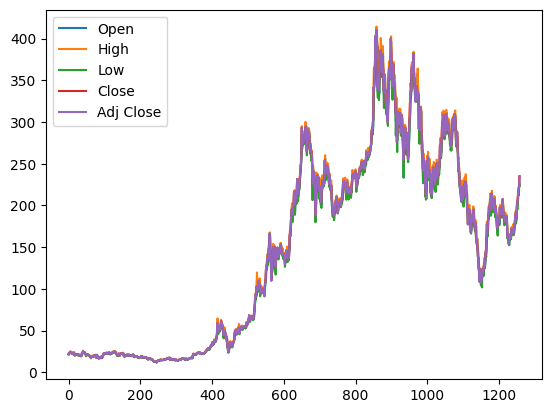

In [4]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

# Splitting the training data 

In [5]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5 (number of colums we choose in th earlier step). 
# We will make timesteps = 14 (past days data used for training). 
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days one wants to look into the future based on the past days.
n_past = 14  # Number of past days one wants to use to predict the future.

In [6]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1244, 14, 5).
trainY shape == (1244, 1).


* In my example, my df_for_training_scaled has a shape (1244, 5)
1244 refers to the number of data points and 5 refers to the columns (multi-variables). #In my case, trainX has a shape (1244, 14, 5). 
12809 because we are looking back 14 days (1244 - 14 = 1231). 
Remember that we cannot look back 14 days until we get to the 15th day. 
* Also, trainY has a shape (1244, 1). Our model only predicts a single value, but 
it needs multiple variables (5 in my example) to make this prediction. 
* This is why we can only predict a single day after our training, the day after where our data ends.
* To predict more days in future, we need all the 5 variables which we do not have. 
* We need to predict all variables if we want to do that. 


# Building the Model 

In [7]:
# defining the LSTM model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
70/70 [==============================] - 6s 33ms/step - loss: 0.1544 - val_loss: 0.0203
Epoch 2/10
70/70 [==============================] - 2s 22ms/step - loss: 0.0476 - val_loss: 0.0189
Epoch 3/10
70/70 [==============================] - 1s 18ms/step - loss: 0.0394 - val_loss: 0.0119
Epoch 4/10
70/70 [==============================] - 2s 23ms/step - loss: 0.0312 - val_loss: 0.0113
Epoch 5/10
70/70 [==============================] - 1s 20ms/step - loss: 0.0360 - val_loss: 0.0140
Epoch 6/10
70/70 [==============================] - 1s 20ms/step - loss: 0.0364 - val_loss: 0.0111
Epoch 7/10
70/70 [==============================] - 1s 17ms/step - loss: 0.0309 - val_loss: 0.0133
Epoch 8/10
70/70 [==============================] - 1s 16ms/step - loss: 0.0313 - val_loss: 0.0105
Epoch 9/10
70/70 [==============================] - 1s 10ms/step - loss: 0.0329 - val_loss: 0.0099
Epoch 10/10
70/70 [==============================] - 1s 10ms/step - loss: 0.0298 - val_loss: 0.0093


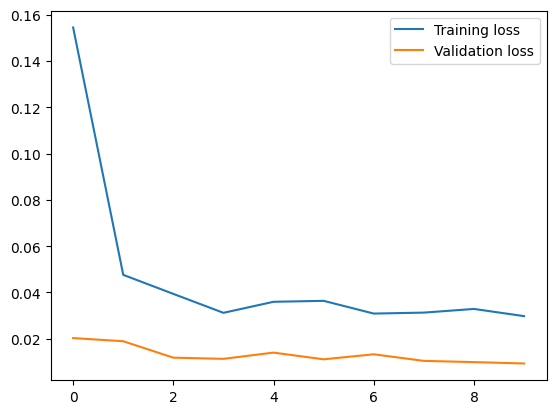

In [8]:
# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# Prediction 

In [9]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

#Forecasting...
#Start with the last day in training date and predict future...
n_future=90  #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

forecast = model.predict(trainX[-n_future:]) #forecast 
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

[Timestamp('2023-05-17 00:00:00', freq='C'), Timestamp('2023-05-18 00:00:00', freq='C'), Timestamp('2023-05-19 00:00:00', freq='C'), Timestamp('2023-05-22 00:00:00', freq='C'), Timestamp('2023-05-23 00:00:00', freq='C'), Timestamp('2023-05-24 00:00:00', freq='C'), Timestamp('2023-05-25 00:00:00', freq='C'), Timestamp('2023-05-26 00:00:00', freq='C'), Timestamp('2023-05-30 00:00:00', freq='C'), Timestamp('2023-05-31 00:00:00', freq='C'), Timestamp('2023-06-01 00:00:00', freq='C'), Timestamp('2023-06-02 00:00:00', freq='C'), Timestamp('2023-06-05 00:00:00', freq='C'), Timestamp('2023-06-06 00:00:00', freq='C'), Timestamp('2023-06-07 00:00:00', freq='C')]
1/1 [==============================] - 0s 26ms/step


In [22]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] <= '2023-05-17']




1/1 [==============================] - 0s 21ms/step


<ipython-input-22-bb6002a03520>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
import plotly.graph_objects as go

# Filter the original data based on the date range for the last six months
last_six_months = pd.to_datetime('today') - pd.DateOffset(months=6)
original_filtered = original.loc[original['Date'] >= last_six_months]

# Create traces for original and forecast data
trace_original = go.Scatter(x=original_filtered['Date'], y=original_filtered['Open'], name='Original')
trace_forecast = go.Scatter(x=df_forecast['Date'], y=df_forecast['Open'], name='Forecast')

# Create the layout
layout = go.Layout(
    title='Original vs Forecast (Last Six Months)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Open')
)

# Create the figure and add the traces
fig = go.Figure(data=[trace_original, trace_forecast], layout=layout)

# Display the plot
fig.show()



In [25]:
#just to check the accuracy 
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] <= '2023-06-08']

# Filter the original data based on the date range for the last six months
last_six_months = pd.to_datetime('today') - pd.DateOffset(months=6)
original_filtered = original.loc[original['Date'] >= last_six_months]

# Create traces for original and forecast data
trace_original = go.Scatter(x=original_filtered['Date'], y=original_filtered['Open'], name='Original')
trace_forecast = go.Scatter(x=df_forecast['Date'], y=df_forecast['Open'], name='Forecast')

# Create the layout
layout = go.Layout(
    title='Original vs Forecast (Last Six Months)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Open')
)

# Create the figure and add the traces
fig = go.Figure(data=[trace_original, trace_forecast], layout=layout)

# Display the plot
fig.show()

<ipython-input-25-dc52c598faf4>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

